## Diffusion Tensor Imaging

### Conversion of CT data

In [1]:
# Loading CT data
img_path="https://github.com/Topaz765/DTI-Porous-media/raw/refs/heads/main/Empty%20scaffold.tif";

In [2]:
using HTTP, Images, FileIO

# Download the file from the URL
response = HTTP.get(img_path)

# Save the file to a temporary location
file_path = "downloaded_image.tif"
open(file_path, "w") do file
    write(file, response.body)
end

#Load the image
img=load(file_path);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:02


In [3]:
# Will stack the image to produce a cubic array
# This assumes an array of size a x a x b where a>b
function fillingfull(img)
    a=size(img)[1]; b=size(img)[3]
    c = Int(ceil(a/b)); d = Int(c*b)
    box = zeros(a,a,d)
    for z in 1:c
        for i in 1:a, j in 1:a, k in 1:b
            box[i,j,Int(k+b*(z-1))] = img[i,j,k]
        end
    end
    
    Box=box[:,:,1:size(box)[1]]
    return Box
end
img=fillingfull(img);

If it not already binarized, this will convert each voxel to either a 1 or a 0, and use this to select the correct size. Thus producing the structure function

In [4]:
A=convert(Array{Float32,3},img[:,:,:])
Gray.(A[:,:,10])
# Pores are given a value of 0, solid material is given a value of 1
b=map(x->x<0.5 ? UInt8(1) : UInt8(0), A)
img_dim=size(b)[1]
rho=b[:,:,:];

### DTI

In [21]:
using Distributed
# Add as many processors as desired
addprocs(0)
@everywhere using LinearAlgebra, Distributed, Distributions, SharedArrays, Random, Measures, Interpolations, HDF5, CSV, DataFrames, Plots;

In [6]:
# Function to produce random walk within given structure function
@everywhere function diffusion_trajectory(Δ,rho;nmax=size(rho)[1])
    
    # Setting up blank arrays for the jump, particle initial position, and list of trajectories
    jump = zeros(Float32,3)
    new = zeros(Float32,3)
    sides = Array{Float32}[]
    
    n = 5000 #The number of successful steps to take
    x = Δ / n #The time step for each random step
    ran = Normal(0,sqrt(x*2*D)/a) #The normal distribution from which the random step size is derived (based on the step time)

    #Selecting a random initial point from a central cube
    while true
        pos=[rand(150:362),rand(150:362),rand(150:362)]
        if (rho[pos...]==0)
            push!(sides,pos)
            break
            false
        end
    end
    pos = sides[1]
    
    # Taking random steps that lie within the pores of the structure function
    k=1
    while k<=n
        jump=rand(ran,3) .|> (x->convert(Float32,x))
        new=pos+jump
            new=new.|>(x->x>nmax ? nmax-(x-nmax) : x)
            new=new.|>(x->x<1 ? 1+(1-x) : x)
        k+=1
        if rho[new...] <= 0.5
            pos=new
        else k=k-1
        end
    end
    push!(sides,new)
    
    return sides
end

In [7]:
# Interpolating structure function
rho = interpolate(rho, BSpline(Linear()));

In [8]:
# Setting up parameters
@everywhere begin
a = 6.00e-6          # resolution of u-CT data (meters)    
D = 2.2e-10          # diffusion coefficient
n = 2e1;             # number of molecules to average
end

In [9]:
#A function to measure the difference between two vectors
@everywhere dist(tj) = sqrt((tj[1][1]-tj[2][1])^2 + (tj[1][2]-tj[2][2])^2 + (tj[1][3]-tj[2][3])^2)

In [10]:
# A function to calculate the diffusion matrix for one diffusion time
@everywhere function diff_tensor(n,rho,Δ)
    
    #Setting up empty arrays to contain the elements of the diffusion tensor
    Dxx = convert(SharedArray{Float32,1},zeros(1)); Dyy = convert(SharedArray{Float32,1},zeros(1)) 
    Dzz = convert(SharedArray{Float32,1},zeros(1)); Dxy = convert(SharedArray{Float32,1},zeros(1))
    Dxz = convert(SharedArray{Float32,1},zeros(1)); Dyz = convert(SharedArray{Float32,1},zeros(1))
    av_dist = convert(SharedArray{Float32,1},zeros(1))
        
    @sync @distributed for i in 1:n
        tj = diffusion_trajectory(Δ,rho) #Producing list of step trajectories
        #Summing the value of each diffusion coefficient for each vector in the trajectory list
        Dxx[1] = Dxx[1] + ((tj[1][1] - tj[2][1])*a)^2 / (2*Δ)
        Dyy[1] = Dyy[1] + ((tj[1][2] - tj[2][2])*a)^2 / (2*Δ)
        Dzz[1] = Dzz[1] + ((tj[1][3] - tj[2][3])*a)^2 / (2*Δ)
            
        Dxy[1] = Dxy[1] + (((tj[1][1] - tj[2][1]) * (tj[1][2] - tj[2][2]))*a^2) / (2*Δ)
        Dxz[1] = Dxz[1] + (((tj[1][1] - tj[2][1]) * (tj[1][3] - tj[2][3]))*a^2) / (2*Δ)
        Dyz[1] = Dyz[1] + (((tj[1][2] - tj[2][2]) * (tj[1][3] - tj[2][3]))*a^2) / (2*Δ)
        
        av_dist[1] = av_dist[1] + dist(tj)

    end
    
    #Averaging the diffusion tensor elements of the number of steps taken
    Dp = [Dxx Dxy Dxz ; Dxy Dyy Dyz ; Dxz Dyz Dzz]./n
    av_dist = av_dist./n
         
    return Dp, av_dist
end

In [11]:
# A function to measure the tortuosity as a function of diffusion times
@everywhere begin
    function tortuosity_undiag(shape,times)
    
        #Setting up empty arrays to host the tensor elements
        Dxx = convert(SharedArray{Float32,1},zeros(length(times))); Dxy = convert(SharedArray{Float32,1},zeros(length(times)))
        Dxz = convert(SharedArray{Float32,1},zeros(length(times))); Dyy = convert(SharedArray{Float32,1},zeros(length(times)))
        Dyz = convert(SharedArray{Float32,1},zeros(length(times))); Dzz = convert(SharedArray{Float32,1},zeros(length(times)))
        @sync @distributed for i in 1:length(times)
            mat = diff_tensor(n,shape,times[i])[1] #Producing the diffusion tensor
            #fit[i] = 1/3*tr(mat) #Calculating the tensor trace
            #Assigning each element within the diffusion tensor
            Dxx[i] = mat[1] ; Dxy[i] = mat[2] 
            Dxz[i] = mat[3] ; Dyy[i] = mat[5] 
            Dyz[i] = mat[8] ; Dzz[i] = mat[9]
        end
    
        return Dxx, Dxy, Dxz, Dyy, Dyz, Dzz
    end
end

In [12]:
# A function to diagonalize the matricies at each diffusion time
@everywhere begin
    function diagonalise(undiag,times)
        
        #Setting up empty arrays to host the tensor elements and trace
        Tort = convert(SharedArray{Float32,1},zeros(length(times))); D_xx = convert(SharedArray{Float32,1},zeros(length(times)))
        D_yy = convert(SharedArray{Float32,1},zeros(length(times))); D_zz = convert(SharedArray{Float32,1},zeros(length(times)))
        
        @sync @distributed for i in 1:length(times)
        Mat=[undiag[1][i] undiag[2][i] undiag[3][i] ; undiag[2][i] undiag[4][i] undiag[5][i] ; undiag[3][i] undiag[5][i] undiag[6][i]]
            eigenvals = eigvals(Mat)
            D_xx[i] = eigenvals[1]
            D_yy[i] = eigenvals[2]
            D_zz[i] = eigenvals[3]
            Tort[i] = ((D_xx[i]+D_yy[i]+D_zz[i])/3)/D         
        end
    
        return Tort, D_xx, D_yy, D_zz
    end
end

In [13]:
#The list of diffusion times to measure
times = vcat([0.01,1,10],[i for i in 30:30:240]);

In [14]:
#Measuring the tortuosity for undiagonalized matricies
@time tort_undiag = tortuosity_undiag(rho,times);

 13.855328 seconds (29.28 M allocations: 1.145 GiB, 12.99% gc time, 42.57% compilation time)


In [15]:
#Measuring the tortuosity for diagonalized matricies
@time tort_diag = diagonalise(tort_undiag,times);

  1.408651 seconds (990.81 k allocations: 52.468 MiB, 1.86% gc time, 98.68% compilation time)


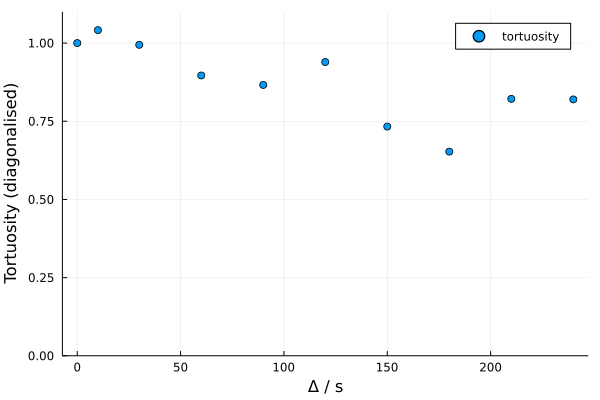

In [16]:
# Tortuosity plot
plot(times,tort_diag[1]./tort_diag[1][1], xlabel = "Δ / s", ylabel = "Tortuosity (diagonalised)", label = "tortuosity", seriestype=:scatter,ylims=(0,1.1))

### Saving the data

In [17]:
# Setting up save parameters
function param(times,rho)
    Params = ["resolution", "Diff coeff", "no. of molecules averaged", "cube dimension", "centre cube","Porosity"]
    Params = [push!(Params,string(0)) for i in 1:length(times)-length(Params)][1]
    Values = [a, D, n, size(rho)[1],(150:362),(size(rho)[1]^3-sum(rho))/size(rho)[1]^3]
    Values = [append!(Values,0) for i in 1:length(times)-length(Values)][1]
    return Params, Values
end

param (generic function with 1 method)

In [20]:
# Saving undiagonalised data
# The number of diffusion times must be greater than 6 (no. of parameters)
df=DataFrame(diffusion_times_s=times,
        Dxx=tort_undiag[1],Dxy=tort_undiag[2],Dxz=tort_undiag[3],Dyy=tort_undiag[4],Dyz=tort_undiag[5],Dzz=tort_undiag[6],
    Params = param(times,rho)[1], Values = param(times,rho)[2])
cd("*insert user save location*")
CSV.write("Test_undiag.csv",df[:,:]);

In [19]:
# Saving diagonalised data
# The number of diffusion times must be greater than 6 (no. of parameters)
df=DataFrame(diffusion_times_s=times,
        D_Delta=tort_diag[1],D_xx=tort_diag[2],D_yy=tort_diag[3],D_zz=tort_diag[4],
    Params = param(times,rho)[1], Values = param(times,rho)[2])
cd("*insert user save location*")
CSV.write("Test_diag.csv",df[:,:]);